In [64]:
import pandas as pd

In [65]:
FireData = pd.read_excel("fp-historical-wildfire-data-2006-2024.xlsx")

print(FireData.head(5))

   YEAR FIRE_NUMBER FIRE_NAME  CURRENT_SIZE SIZE_CLASS   LATITUDE   LONGITUDE  \
0  2011      MWF047       NaN          1.60          B  58.952257 -111.030739   
1  2022      EWF078       NaN          0.01          A  53.289033 -117.479300   
2  2024      LWF121       NaN          0.67          B  55.012667 -113.450700   
3  2021      LWF065       NaN          0.10          A  54.567167 -111.198100   
4  2006      GWF033       NaN          0.04          A  55.681383 -119.527050   

       FIRE_ORIGIN       GENERAL_CAUSE INDUSTRY_IDENTIFIER  ...  \
0  Provincial Land           Lightning                 NaN  ...   
1  Provincial Land           Lightning                 NaN  ...   
2  Provincial Land           Lightning                 NaN  ...   
3  Provincial Land          Incendiary                 NaN  ...   
4  Provincial Land  Oil & Gas Industry                 NaN  ...   

  DISTANCE_FROM_WATER_SOURCE FIRST_BUCKET_DROP_DATE        FIRST_BH_DATE  \
0                        0.2    20

In [66]:
null_counts = FireData.isnull().sum()
print(null_counts[null_counts > 0])

FIRE_NAME                       25756
FIRE_ORIGIN                        12
INDUSTRY_IDENTIFIER             26071
RESPONSIBLE_GROUP               17029
ACTIVITY_CLASS                  10416
TRUE_CAUSE                      12529
FIRE_START_DATE                   689
DISCOVERED_DATE                  5409
DISCOVERED_SIZE                 26402
DISPATCHED_RESOURCE                12
DISPATCH_DATE                      12
START_FOR_FIRE_DATE                17
FIRE_SPREAD_RATE                 2806
FIRE_TYPE                        2617
FIRE_POSITION_ON_SLOPE           2863
WEATHER_CONDITIONS_OVER_FIRE     2870
TEMPERATURE                      2872
RELATIVE_HUMIDITY                2878
WIND_DIRECTION                   2880
WIND_SPEED                       2880
FUEL_TYPE                        7559
INITIAL_ACTION_BY                  17
IA_ARRIVAL_AT_FIRE_DATE          7703
IA_ACCESS                       14858
FIRE_FIGHTING_START_DATE         7572
FIRE_FIGHTING_START_SIZE         7572
BUCKETING_ON

In [67]:
FireData.dtypes

YEAR                              int64
FIRE_NUMBER                      object
FIRE_NAME                        object
CURRENT_SIZE                    float64
SIZE_CLASS                       object
LATITUDE                        float64
LONGITUDE                       float64
FIRE_ORIGIN                      object
GENERAL_CAUSE                    object
INDUSTRY_IDENTIFIER              object
RESPONSIBLE_GROUP                object
ACTIVITY_CLASS                   object
TRUE_CAUSE                       object
FIRE_START_DATE                  object
DETECTION_AGENT_TYPE             object
DETECTION_AGENT                  object
DISCOVERED_DATE                  object
DISCOVERED_SIZE                 float64
REPORTED_DATE                    object
DISPATCHED_RESOURCE              object
DISPATCH_DATE                    object
START_FOR_FIRE_DATE              object
ASSESSMENT_RESOURCE              object
ASSESSMENT_DATETIME              object
ASSESSMENT_HECTARES             float64


In [68]:
FireData_CLEAN = FireData.copy() #Create a copy of adjustments

In [69]:
FireData_CLEAN["YEAR"].unique() #look for unique values 

#Looks good overall no changes necessary

array([2011, 2022, 2024, 2021, 2006, 2009, 2008, 2007, 2010, 2019, 2014,
       2016, 2012, 2013, 2015, 2017, 2018, 2020, 2023])

In [70]:
#Edit Date fields first 

# complete data validation on the date columns

# 1) Define ALL your date/time columns (semantic list, not just dtype)
date_cols = [
    "FIRE_START_DATE",
    "REPORTED_DATE",
    "DISCOVERED_DATE",
    "DISPATCH_DATE",
    "START_FOR_FIRE_DATE",
    "ASSESSMENT_DATETIME",
    "IA_ARRIVAL_AT_FIRE_DATE",
    "FIRE_FIGHTING_START_DATE",
    "FIRST_BH_DATE",
    "FIRST_UC_DATE",
    "FIRST_EX_DATE",
    "DISPATCH_DATE_DERIVED",
]

# Keep only columns that actually exist in the DataFrame 
date_cols = [c for c in date_cols if c in FireData.columns]

# 2) Convert all to datetime (invalid values -> NaT)
for col in date_cols:
    FireData[col] = pd.to_datetime(FireData[col], errors="coerce")

# 3) Basic completeness + year-range checks
CURRENT_YEAR = 2025
MIN_YEAR = 1900

date_summary = pd.DataFrame({
    "MISSING_COUNT": FireData[date_cols].isna().sum(),
    "MISSING_PCT": (FireData[date_cols].isna().mean() * 100).round(2),
    "MIN_YEAR": FireData[date_cols].apply(lambda s: s.dt.year.min()),
    "MAX_YEAR": FireData[date_cols].apply(lambda s: s.dt.year.max()),
})

# Rows outside plausible year range (counts)
out_of_range_counts = {}
for col in date_cols:
    out_of_range_counts[col] = (
        (FireData[col].notna()) &
        ((FireData[col].dt.year < MIN_YEAR) | (FireData[col].dt.year > CURRENT_YEAR))
    ).sum()

date_summary["OUT_OF_RANGE_COUNT"] = pd.Series(out_of_range_counts)

print("=== DATE SUMMARY ===")
print(date_summary.sort_values("MISSING_PCT", ascending=False))

# 4) Logical ordering checks 
order_checks = [
    ("FIRE_START_DATE", "DISCOVERED_DATE"),
    ("DISCOVERED_DATE", "REPORTED_DATE"),
    ("REPORTED_DATE", "DISPATCH_DATE"),
    ("DISPATCH_DATE", "ASSESSMENT_DATETIME"),
    ("ASSESSMENT_DATETIME", "IA_ARRIVAL_AT_FIRE_DATE"),
    ("DISPATCH_DATE", "IA_ARRIVAL_AT_FIRE_DATE"),
    ("IA_ARRIVAL_AT_FIRE_DATE", "FIRE_FIGHTING_START_DATE"),
    ("DISPATCH_DATE_DERIVED", "IA_ARRIVAL_AT_FIRE_DATE"),
    ("REPORTED_DATE", "FIRST_BH_DATE"),
    ("REPORTED_DATE", "FIRST_UC_DATE"),
    ("REPORTED_DATE", "FIRST_EX_DATE"),
]

print("\n=== DATE ORDER VIOLATIONS (A > B) ===")
for a, b in order_checks:
    if a in FireData.columns and b in FireData.columns:
        mask = FireData[a].notna() & FireData[b].notna() & (FireData[a] > FireData[b])
        print(f"{a} > {b}: {mask.sum()} rows")
        if mask.any():
            print(FireData.loc[mask, [a, b]].head(5))

# 5) Timing difference sanity checks (descriptive stats)
timedelta_checks = [
    ("REPORT_VS_DISCOVERED", "REPORTED_DATE", "DISCOVERED_DATE"),
    ("DISPATCH_VS_REPORTED", "DISPATCH_DATE", "REPORTED_DATE"),
    ("ASSESSMENT_VS_DISPATCH", "ASSESSMENT_DATETIME", "DISPATCH_DATE"),
    ("ARRIVAL_VS_DISPATCH", "IA_ARRIVAL_AT_FIRE_DATE", "DISPATCH_DATE"),
]

for name, end_col, start_col in timedelta_checks:
    if end_col in FireData.columns and start_col in FireData.columns:
        td = FireData[end_col] - FireData[start_col]
        print(f"\n=== {name} (Timedelta) DESCRIBE ===")
        print(td.dropna().describe())

# 6) Create flag columns (good for documentation)
for col in date_cols:
    FireData[f"{col}_OUT_OF_RANGE"] = (
        FireData[col].notna() &
        ((FireData[col].dt.year < MIN_YEAR) | (FireData[col].dt.year > CURRENT_YEAR))
    )

print("\nDone. 'date_summary' is your audit table; *_OUT_OF_RANGE columns and violation prints document issues.")



C:\Users\samkl\AppData\Local\Temp\ipykernel_16656\861308995.py:26: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  FireData[col] = pd.to_datetime(FireData[col], errors="coerce")


=== DATE SUMMARY ===
                          MISSING_COUNT  MISSING_PCT  MIN_YEAR  MAX_YEAR  \
IA_ARRIVAL_AT_FIRE_DATE            7703        29.01    2006.0    2220.0   
FIRE_FIGHTING_START_DATE           7572        28.52    2006.0    2220.0   
DISCOVERED_DATE                    5409        20.37    2006.0    2024.0   
FIRE_START_DATE                     693         2.61    2000.0    2024.0   
START_FOR_FIRE_DATE                  17         0.06    2006.0    2024.0   
DISPATCH_DATE                        12         0.05    2006.0    2024.0   
FIRST_EX_DATE                         6         0.02    2006.0    2024.0   
REPORTED_DATE                         0         0.00    2006.0    2024.0   
ASSESSMENT_DATETIME                   0         0.00    2006.0    2024.0   
FIRST_BH_DATE                         0         0.00    2006.0    2024.0   
FIRST_UC_DATE                         0         0.00    2006.0    2024.0   

                          OUT_OF_RANGE_COUNT  
IA_ARRIVAL_AT_FIRE_

In [71]:
# Sort for inspection 
#Clean errors on fire_start_date
print(
    FireData_CLEAN["FIRE_START_DATE"]
        .sort_values(ascending=True)
        .head(25)
)


# The "0201/0220/0240/1021" values are out-of-bounds, so after coercion they become NaT.
# Replace those missing FIRE_START_DATE values with the corresponding REPORTED_DATE
# (applied to FireData_CLEAN, not the raw data)

mask = (
    FireData_CLEAN["FIRE_START_DATE"].isna() &
    FireData_CLEAN["REPORTED_DATE"].notna()
)

FireData_CLEAN.loc[mask, "FIRE_START_DATE"] = FireData_CLEAN.loc[mask, "REPORTED_DATE"]

# 3) Re-coerce again to guarantee dtype stays datetime (sometimes mixed assigns can keep object)
FireData_CLEAN["FIRE_START_DATE"] = pd.to_datetime(FireData_CLEAN["FIRE_START_DATE"], errors="coerce")

# Verify the fix
print(
    "FIRE_START_DATE NaT remaining:",
    FireData_CLEAN["FIRE_START_DATE"].isna().sum()
)

0     0201-10-06 23:18:00
1     0220-08-22 17:17:00
2     0240-07-11 11:05:00
3     1021-04-24 12:00:00
4     2000-05-02 10:35:00
5     2000-05-24 13:40:00
6     2000-06-04 12:21:00
7     2004-01-07 15:13:00
8     2004-04-20 13:30:00
9     2005-04-14 18:00:00
10    2005-04-30 16:30:00
11    2005-05-06 17:00:00
12    2005-05-13 20:30:00
13    2005-05-20 18:30:00
14    2005-05-22 17:20:00
15    2005-08-19 08:00:00
16    2005-11-01 10:00:00
17    2005-11-01 10:00:00
18    2005-11-01 12:00:00
19    2005-11-15 15:00:00
20    2005-11-21 16:00:00
21    2005-12-01 10:00:00
22    2005-12-15 13:00:00
23    2005-12-31 10:00:00
24    2006-01-01 10:00:00
Name: FIRE_START_DATE, dtype: object
FIRE_START_DATE NaT remaining: 4


C:\Users\samkl\AppData\Local\Temp\ipykernel_16656\33883453.py:22: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  FireData_CLEAN["FIRE_START_DATE"] = pd.to_datetime(FireData_CLEAN["FIRE_START_DATE"], errors="coerce")


In [72]:
#Reported date has no dates out of range or missing values

#Discovered Date is the date of discovery, which is a mandatory field except for when it's marked as unplanned. Then it does not have to be populated. This seems like a major data issue. I cannot fill in the blank with a value here but it's worth noting in my paper

In [73]:
#Clean errors on fire_data_ fire fighting start date 
print(
    FireData_CLEAN["FIRE_FIGHTING_START_DATE"]
        .sort_values(ascending=False)
        .head(25)
)


# 1) Work as strings so we can safely replace "future" years
FireData_CLEAN["FIRE_FIGHTING_START_DATE"] = (
    FireData_CLEAN["FIRE_FIGHTING_START_DATE"]
        .astype("string")
        .str.strip()
        .replace({
            "2220-07-05 19:30:00": "2020-07-05 19:30:00",
            "2202-06-17 15:30:00": "2002-06-17 15:30:00",
            "2160-06-25 15:07:00": "2016-06-25 15:07:00",
            "2090-09-05 11:08:00": "2009-09-05 11:08:00",
            "2090-06-12 10:52:00": "2009-06-12 10:45:00",
            "2090-05-17 18:40:00": "2009-05-17 18:40:00",
            "2090-05-17 14:50:00": "2009-05-17 14:50:00",
            "2090-05-01 20:45:00": "2009-05-01 20:39:00",
            "2080-05-19 14:46:00": "2008-05-19 14:50:00",
            "2070-07-02 16:00:00": "2007-07-02 16:00:00",
            "2060-09-04 15:30:00": "2006-09-04 15:30:00",
            "2050-05-09 14:52:00": "2015-05-09 14:52:00",
            "2040-05-20 17:43:00": "2024-05-20 17:43:00",
            "2030-08-06 16:07:00": "2023-08-06 16:04:00",
            "2027-08-04 20:33:00": "2024-08-04 20:30:00",
            "2025-06-29 15:08:00": "2024-06-29 15:08:00",
        })
)

# 2) Convert back to datetime
FireData_CLEAN["FIRE_FIGHTING_START_DATE"] = pd.to_datetime(
    FireData_CLEAN["FIRE_FIGHTING_START_DATE"],
    errors="coerce"
)

# 3) Validate: print anything still out of range
MIN_YEAR = 1900
CURRENT_YEAR = 2025

remaining_bad = FireData_CLEAN.loc[
    FireData_CLEAN["FIRE_FIGHTING_START_DATE"].notna() &
    (
        (FireData_CLEAN["FIRE_FIGHTING_START_DATE"].dt.year < MIN_YEAR) |
        (FireData_CLEAN["FIRE_FIGHTING_START_DATE"].dt.year > CURRENT_YEAR)
    ),
    ["FIRE_NUMBER", "FIRE_FIGHTING_START_DATE"]
]

print("Remaining out-of-range FIRE_FIGHTING_START_DATE rows:")
print(remaining_bad)

# Optional quick check: show latest dates after fixes
print(
    FireData_CLEAN["FIRE_FIGHTING_START_DATE"]
    .sort_values(ascending=False)
    .head(20)
)


22823    2220-07-05 19:30:00
22738    2202-06-17 15:30:00
16299    2160-06-25 15:07:00
6482     2090-09-05 11:08:00
5703     2090-06-12 10:52:00
5415     2090-05-17 18:40:00
5404     2090-05-17 14:50:00
5171     2090-05-01 20:45:00
3727     2080-05-19 14:46:00
2589     2070-07-02 16:00:00
1797     2060-09-04 15:30:00
14014    2050-05-09 14:52:00
25008    2040-05-20 17:43:00
24481    2030-08-06 16:07:00
25679    2027-08-04 20:33:00
25138    2025-06-29 15:08:00
25861    2024-11-22 16:17:00
25858    2024-11-22 10:05:00
25857    2024-11-22 07:00:00
25860    2024-11-21 10:07:00
25856    2024-11-20 12:00:00
25852    2024-11-14 11:00:00
25847    2024-10-28 14:32:00
25844    2024-10-25 12:48:00
26545    2024-10-18 12:58:00
Name: FIRE_FIGHTING_START_DATE, dtype: object
Remaining out-of-range FIRE_FIGHTING_START_DATE rows:
Empty DataFrame
Columns: [FIRE_NUMBER, FIRE_FIGHTING_START_DATE]
Index: []
25861   2024-11-22 16:17:00
25858   2024-11-22 10:05:00
25857   2024-11-22 07:00:00
25860   2024-11-

In [74]:
# Inspect the latest (largest) values first
print(
    FireData_CLEAN["IA_ARRIVAL_AT_FIRE_DATE"]
        .astype("string")
        .sort_values(ascending=False)
        .head(25)
)


# Work as string
s = FireData_CLEAN["IA_ARRIVAL_AT_FIRE_DATE"].astype("string").str.strip()


s = s.str.replace(r"^2220-07-05 18:30:00.*$", "2022-07-05 18:30:00", regex=True)

FireData_CLEAN["IA_ARRIVAL_AT_FIRE_DATE"] = pd.to_datetime(s, errors="coerce")

# Verify
remaining_2220 = FireData_CLEAN["IA_ARRIVAL_AT_FIRE_DATE"].astype("string").str.contains("2220", na=False).sum()
print("Remaining '2220' IA_ARRIVAL_AT_FIRE_DATE values:", remaining_2220)

print(
    FireData_CLEAN["IA_ARRIVAL_AT_FIRE_DATE"]
        .sort_values(ascending=False)
        .head(25)
)


22823    2220-07-05 18:30:00
25861    2024-11-22 16:15:00
25857    2024-11-22 07:00:00
25860    2024-11-21 10:06:00
25858    2024-11-21 09:30:00
25856    2024-11-19 15:35:00
25852    2024-11-14 10:30:00
25847    2024-10-28 14:22:00
25844    2024-10-25 12:30:00
26545    2024-10-18 12:58:00
25836    2024-10-14 16:55:00
25809    2024-10-14 16:48:00
25834    2024-10-12 18:05:00
25830    2024-10-08 20:18:00
25822    2024-10-08 17:45:00
25810    2024-10-07 12:09:00
25817    2024-10-06 16:04:00
25816    2024-10-06 14:10:00
25813    2024-10-05 10:58:00
25803    2024-09-27 14:05:00
25802    2024-09-27 11:25:00
25794    2024-09-24 17:31:00
25798    2024-09-24 15:42:00
25797    2024-09-21 18:55:00
25796    2024-09-21 12:49:00
Name: IA_ARRIVAL_AT_FIRE_DATE, dtype: string
Remaining '2220' IA_ARRIVAL_AT_FIRE_DATE values: 0
25861   2024-11-22 16:15:00
25857   2024-11-22 07:00:00
25860   2024-11-21 10:06:00
25858   2024-11-21 09:30:00
25856   2024-11-19 15:35:00
25852   2024-11-14 10:30:00
25847   202

In [75]:
# For the small subset of records missing dispatch timestamps, a derived dispatch date was conservatively
# estimated using the earliest documented response action, constrained to occur no earlier than the
# reported date. These records were explicitly flagged and the original dispatch field was retained.

# Ensure all relevant columns are datetime (FireData_CLEAN)
cols = [
    "DISPATCH_DATE",
    "REPORTED_DATE",
    "FIRST_BH_DATE",
    "FIRST_UC_DATE",
    "FIRST_EX_DATE",
]

for c in cols:
    FireData_CLEAN[c] = pd.to_datetime(FireData_CLEAN[c], errors="coerce")

# Flag rows with missing dispatch date
mask_missing_dispatch = FireData_CLEAN["DISPATCH_DATE"].isna()

# Create derived dispatch date (do NOT overwrite original)
FireData_CLEAN["DISPATCH_DATE_DERIVED"] = FireData_CLEAN["DISPATCH_DATE"]

# Earliest confirmed response action
earliest_action = (
    FireData_CLEAN.loc[mask_missing_dispatch, [
        "FIRST_BH_DATE",
        "FIRST_UC_DATE",
        "FIRST_EX_DATE",
    ]]
    .min(axis=1)
)

# Dispatch must be >= reported date (conservative lower bound)
FireData_CLEAN.loc[mask_missing_dispatch, "DISPATCH_DATE_DERIVED"] = (
    earliest_action.combine(
        FireData_CLEAN.loc[mask_missing_dispatch, "REPORTED_DATE"],
        max
    )
)

# Flag imputed records for transparency
FireData_CLEAN["DISPATCH_DATE_IMPUTED"] = mask_missing_dispatch


In [76]:
# Calculate percent of nulls per column (FireData_CLEAN)
null_pct = FireData_CLEAN.isnull().mean()

high_null_cols = null_pct[null_pct > 0.60]

print(high_null_cols)

# These columns are majority null and do not add analytical value → drop from CLEAN dataset
FireData_CLEAN = FireData_CLEAN.drop(
    columns=[
        "RESPONSIBLE_GROUP",
        "DISCOVERED_SIZE",
        "DISTANCE_FROM_WATER_SOURCE",
        "FIRST_BUCKET_DROP_DATE",
        "FIRST_TO_DATE",
        "FIRST_TO_SIZE",
        "FIRE_NAME",
    ]
)

#fire name has many nulls, I will drop this column and use fire number as the unique idenitifer instead 
#fire origin is mainly complete - will fill in NaN with DND (the cannot determine variable as stated in the data dictionary

FIRE_NAME                     0.970058
INDUSTRY_IDENTIFIER           0.981922
RESPONSIBLE_GROUP             0.641369
DISCOVERED_SIZE               0.994388
DISTANCE_FROM_WATER_SOURCE    0.714022
FIRST_BUCKET_DROP_DATE        0.713984
FIRST_TO_DATE                 0.896727
FIRST_TO_SIZE                 0.896727
dtype: float64


In [77]:
FireData_CLEAN["FIRE_ORIGIN"] = FireData_CLEAN["FIRE_ORIGIN"].fillna("DND")


Examine the general cause and industry identifier columns (should be aligned; if industry is identified as the cause, it should also be reflected in the other column, and vice versa)

In [78]:
FireData_CLEAN["GENERAL_CAUSE"].unique() #look for unique values 

array(['Lightning', 'Incendiary', 'Oil & Gas Industry', 'Recreation',
       'Resident', 'Forest Industry', 'Other Industry', 'Prescribed Fire',
       'Undetermined', 'Railroad', 'Power Line Industry', 'Restart',
       'Agriculture Industry', 'Government', 'Under Investigation'],
      dtype=object)

In [79]:
industry_mask = FireData_CLEAN["GENERAL_CAUSE"].astype(str).str.contains(
    "INDUSTRY|OIL|GAS|POWER|UTILITY|PIPELINE|RAILROAD",
    case=False,
    na=False
)

#groupby the columns that are industry identifiers 

In [80]:
FireData_CLEAN.loc[industry_mask, ["GENERAL_CAUSE", "INDUSTRY_IDENTIFIER"]] \
        .value_counts(dropna=False) \
        .reset_index(name="COUNT")
#compare the mask to the industry ID 

,GENERAL_CAUSE,INDUSTRY_IDENTIFIER,COUNT
0,Power Line Industry,NaN,1429
1,Agriculture Industry,NaN,653
2,Forest Industry,NaN,491
3,Oil & Gas Industry,NaN,467
4,Railroad,NaN,145
5,Other Industry,Comm. Transportation,119
6,Other Industry,Waste Disposal,67
7,Other Industry,Provincial,46
8,Other Industry,Mining,37
9,Other Industry,Municipal,25


Industry ID has too many NAN values, and/or inconsistent values. Dropping the column. 

In [81]:
FireData_CLEAN = FireData_CLEAN.drop(columns=['INDUSTRY_IDENTIFIER'])

In [82]:
print(FireData_CLEAN.columns)

Index(['YEAR', 'FIRE_NUMBER', 'CURRENT_SIZE', 'SIZE_CLASS', 'LATITUDE',
       'LONGITUDE', 'FIRE_ORIGIN', 'GENERAL_CAUSE', 'ACTIVITY_CLASS',
       'TRUE_CAUSE', 'FIRE_START_DATE', 'DETECTION_AGENT_TYPE',
       'DETECTION_AGENT', 'DISCOVERED_DATE', 'REPORTED_DATE',
       'DISPATCHED_RESOURCE', 'DISPATCH_DATE', 'START_FOR_FIRE_DATE',
       'ASSESSMENT_RESOURCE', 'ASSESSMENT_DATETIME', 'ASSESSMENT_HECTARES',
       'FIRE_SPREAD_RATE', 'FIRE_TYPE', 'FIRE_POSITION_ON_SLOPE',
       'WEATHER_CONDITIONS_OVER_FIRE', 'TEMPERATURE', 'RELATIVE_HUMIDITY',
       'WIND_DIRECTION', 'WIND_SPEED', 'FUEL_TYPE', 'INITIAL_ACTION_BY',
       'IA_ARRIVAL_AT_FIRE_DATE', 'IA_ACCESS', 'FIRE_FIGHTING_START_DATE',
       'FIRE_FIGHTING_START_SIZE', 'BUCKETING_ON_FIRE', 'FIRST_BH_DATE',
       'FIRST_BH_SIZE', 'FIRST_UC_DATE', 'FIRST_UC_SIZE', 'FIRST_EX_DATE',
       'FIRST_EX_SIZE_PERIMETER', 'DISPATCH_DATE_DERIVED',
       'DISPATCH_DATE_IMPUTED'],
      dtype='object')


In [83]:
FireData_CLEAN["ACTIVITY_CLASS"].unique() #look for unique values 
#going to fill NA values with the field labelled "Unclassified" which is the appropriate field via the dictionary 



array([nan, 'Arson', 'Flaring Gas', 'Cooking', 'Heavy Equipment',
       'Traditional Burning', 'Refuse', 'Grass', 'All Terrain Vehicles',
       'Piles', 'Windrows', 'Slash', 'Brush', 'Unclassified',
       'Lighting Fires', 'Children', 'Ammunition', 'Smoking',
       'Vehicle Trans.', 'Rail Transportation', 'Power Lines', 'Welders',
       'Pipelines', 'Refuelling', 'Power Saw', 'Air Transportation',
       'Operations', 'OHV Operation', 'Debris Disposal',
       'Cooking and Warming', 'Refuse Disposal', 'Transportation',
       'Structure Fire', 'Restart', 'Prescribed Fire'], dtype=object)

In [84]:
FireData_CLEAN["ACTIVITY_CLASS"] = FireData_CLEAN["ACTIVITY_CLASS"].fillna("Unclassified")

In [85]:
FireData_CLEAN["TRUE_CAUSE"].unique() #look for unique values 
#going to fill NA values with the field labelled "Unclassified" which is the appropriate field via the dictionary 


array([nan, 'Flammable Fluids', 'Abandoned Fire', 'High Hazard',
       'Unsafe Fire', 'Permit Related', 'Burning Substance',
       'Unattended Fire', 'Unpredictable Event', 'Arson Suspected',
       'Arson Known', 'Insufficient Buffer', 'Hot Exhaust',
       'Incendiary Device', 'Insufficient Resources', 'Line Impact',
       'Winter Burning', 'Mechanical Failure', 'Unclassified',
       'Vehicle Fire', 'Animals', 'Friction Spark'], dtype=object)

In [86]:
FireData_CLEAN["TRUE_CAUSE"] = FireData_CLEAN["TRUE_CAUSE"].fillna("Unclassified")

Fire detection is a parent/child class and I may wnat to group those later so I classified them as such 

In [87]:

# Base mappings (the “known” subtypes)
DET_AGENT_MAP = {
    # Lookout
    "LKT": "LKT",

    # Air patrol
    "RAP": "AIR",
    "HAC": "AIR",
    "ASU": "AIR",
    "MD":  "AIR",
    "FW":  "AIR",
    "RW":  "AIR",
    "USAT":"AIR",

    # Ground patrol
    "FRST": "GRP",
    "CREW": "GRP",
    "PATR": "GRP",
    "PIND": "GRP",
    "GARD": "GRP",

    # Unplanned
    "310":  "UNP",
    "GOVT": "UNP",
    "LFS":  "UNP",
    "PUB":  "UNP",
    "UAA":  "UNP",
    "UIND": "UNP",
    "UPA":  "UNP",
}

# Mapped to Lookout 
LOOKOUT_IDS = [
    "BT","BR","ZA","LO","WU","PU","ED","PA","SI","YH","BH","DM","MR","CC",
    "FG","KA","SN","EL","TP","DW","CA","HL","GT","EH","RA","AN","BM",
    "RE","BY","ST","AU","WC","MU","PT","EA","HU","RY","PS","MN","CP","RK",
    "SK","BP","AT","BD","GE","IM","BZ","BI","CM","SA","WM","WI","RH","SV",
    "NO","KK","RI","GL","BL","BN","LG","IS","FL","GM","TY","CF","CY","SW",
    "CU","KM","TR","MB","TO","JM","EC","SG","MY","GF","TT","BE","LI","TM",
    "WD","AL","MH","CB","CT","WT","JE","CK","RT","AC","MO","NM","CH","BF",
    "MQ","WF","PO","LV","RR","HH","HK","FT","MS","PL","HM","VG","SQ","DG",
    "BC","CE","SP","OL","PD","BS","LK","SD","AM","AD","FO","JO","YA","SR",
    "HA","OB","HB","KE","KB","IQ","EX"
]

# Add lookout IDs to the mapping dict (all -> LKT)
DET_AGENT_MAP.update({code: "LKT" for code in LOOKOUT_IDS})

# Derive the mapped type
FireData_CLEAN["DET_AGENT_TYPE_DERIVED"] = (
    FireData_CLEAN["DETECTION_AGENT"]
        .astype("string")
        .str.strip()
        .str.upper()
        .map(DET_AGENT_MAP)
)

# Show any unmapped values 
unmapped = (
    FireData_CLEAN.loc[
        FireData_CLEAN["DETECTION_AGENT"].notna() &
        FireData_CLEAN["DET_AGENT_TYPE_DERIVED"].isna(),
        "DETECTION_AGENT"
    ]
    .astype(str).str.strip().str.upper()
    .unique()
)

print("Unmapped DETECTION_AGENT values:", unmapped)


Unmapped DETECTION_AGENT values: []


In [88]:
#drop this column, I am not doing any analysis on the fire slope 

FireData_CLEAN = FireData_CLEAN.drop(columns=['FIRE_POSITION_ON_SLOPE'])

These three columns I want to merge with some temperature data to fill in the missing gaps 
WEATHER_CONDITIONS_OVER_FIRE	TEMPERATURE	RELATIVE_HUMIDITY	WIND_DIRECTION	WIND_SPEED


The columns I need to graph to see what makes the most sense with the data 
FIRE_SPREAD_RATE                
FIRE_TYPE  

In [89]:
FireData_CLEAN["INITIAL_ACTION_BY"].unique() #look for unique values 

array(['HAC1H', 'FPD Staff', 'HAC', 'Industry', 'Fire Department',
       'HAC1F', 'Public', 'Land Owner', 'WFC2', 'HAC1R', 'Other Agency',
       'Air Tanker', 'FTAC', 'RAP', 'UNIT', nan], dtype=object)

In [90]:
#Replace everything that's not HAC with HAC as it is part of the same unit without the idenitfier unit code

FireData_CLEAN["INITIAL_ACTION_BY"] = FireData_CLEAN["INITIAL_ACTION_BY"].replace({
    "HAC1H": "HAC",
    "HAC1R": "HAC",
    "HAC1F": "HAC",
    "WFC2": "HAC",
})

In [91]:
#As per the dictionary these dates do not get updated with actuals I can dropping these and focusing on total burn size, not the size at a reported time FIRST_BH_SIZE FIRST_UC_SIZE FIRST_TO_SIZE	FIRST_EX_SIZE_PERIMETER

FireData_CLEAN = FireData_CLEAN.drop(
    columns=[
        "FIRST_BH_SIZE",
        "FIRST_UC_SIZE",
        "FIRST_EX_SIZE_PERIMETER",
    ]
)


In [92]:
# Count missing values
na_count = FireData_CLEAN["BUCKETING_ON_FIRE"].isna().sum()

# Calculate percentage missing
na_pct = FireData_CLEAN["BUCKETING_ON_FIRE"].isna().mean() * 100

print(f"BUCKETING_ON_FIRE - NA count: {na_count}")
print(f"BUCKETING_ON_FIRE - NA percent: {na_pct:.2f}%")

# Data in this column is inconsistent, and the bucket drop date column
# was already dropped due to excessive null values

FireData_CLEAN = FireData_CLEAN.drop(columns=["BUCKETING_ON_FIRE"])


BUCKETING_ON_FIRE - NA count: 7770
BUCKETING_ON_FIRE - NA percent: 29.26%


In [93]:
#Unable to do analysis with temperature with a predictor with null values, going to drop these columns 

FireData_CLEAN = FireData_CLEAN.dropna(subset=["TEMPERATURE"])

In [94]:
# fill remaining null values in FIRE_START_DATE with REPORTED_DATE (6 rows)

FireData_CLEAN["FIRE_START_DATE"] = FireData_CLEAN["FIRE_START_DATE"].fillna(
    FireData_CLEAN["REPORTED_DATE"]
)


In [95]:
#TIME FOR FIRE TO BE UNDER CONTROL 
FireData_CLEAN["UNDER_CONTROL"] = (
    FireData_CLEAN["FIRST_UC_DATE"] - FireData_CLEAN["FIRE_START_DATE"]
)

#TIME FOR FIRE TO BE EXTINGUISHED
FireData_CLEAN["EXTINGUISHED"] = (
    FireData_CLEAN["FIRST_EX_DATE"] - FireData_CLEAN["FIRE_START_DATE"]
)

In [96]:
# Timedelta (keeps full precision)
FireData_CLEAN["TIME_TO_DISPATCH"] = (
    FireData_CLEAN["DISPATCH_DATE"] - FireData_CLEAN["FIRE_START_DATE"]
)

# Numeric days (float)
FireData_CLEAN["TIME_TO_DISPATCH_DAYS"] = (
    FireData_CLEAN["TIME_TO_DISPATCH"].dt.total_seconds() / 86400
)

In [97]:
#fill remaining humidity values with mean 
mean_rh = FireData_CLEAN["RELATIVE_HUMIDITY"].mean()
print(mean_rh)

FireData_CLEAN["RELATIVE_HUMIDITY"] = (
    FireData_CLEAN["RELATIVE_HUMIDITY"]
    .fillna(mean_rh)
)

45.32104084822372


In [98]:
FireData_CLEAN["RELATIVE_HUMIDITY"].isna().sum()


np.int64(0)

In [99]:
FireData_CLEAN.to_excel(
    "FireData_CLEAN.xlsx",
    index=False
)

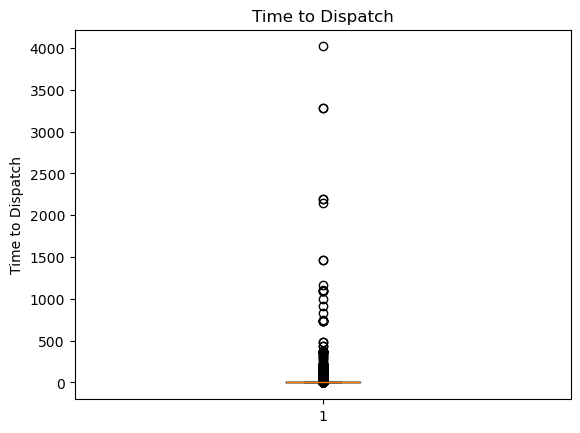

In [100]:
#graph the Time to TIME_TO_DISPATCH as a box diagram 
import matplotlib.pyplot as plt

plt.figure()
plt.boxplot(
    FireData_CLEAN["TIME_TO_DISPATCH_DAYS"].dropna()
)
plt.title("Time to Dispatch")
plt.ylabel("Time to Dispatch")
plt.show()


In [101]:
#there are large outliers in this data

# --- Identify and remove outliers using IQR for TIME_TO_DISPATCH_DAYS ---

# 1. Drop nulls just for the calculation
dispatch_days = FireData_CLEAN["TIME_TO_DISPATCH_DAYS"].dropna()

# 2. Calculate Q1, Q3, and IQR
Q1 = dispatch_days.quantile(0.25)
Q3 = dispatch_days.quantile(0.75)
IQR = Q3 - Q1

# 3. Define lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Lower bound: {lower_bound}")
print(f"Upper bound: {upper_bound}")

# 4. Flag outliers (optional: for inspection)
FireData_CLEAN["DISPATCH_OUTLIER"] = (
    (FireData_CLEAN["TIME_TO_DISPATCH_DAYS"] < lower_bound) |
    (FireData_CLEAN["TIME_TO_DISPATCH_DAYS"] > upper_bound)
)

# 5. Create a cleaned dataset with outliers removed
FireData_NO_OUTLIERS = FireData_CLEAN[
    ~FireData_CLEAN["DISPATCH_OUTLIER"]
].copy()

print("Rows before:", len(FireData_CLEAN))
print("Rows after removing outliers:", len(FireData_NO_OUTLIERS))


Lower bound: -0.7628472222222223
Upper bound: 1.3065972222222224
Rows before: 23679
Rows after removing outliers: 20106


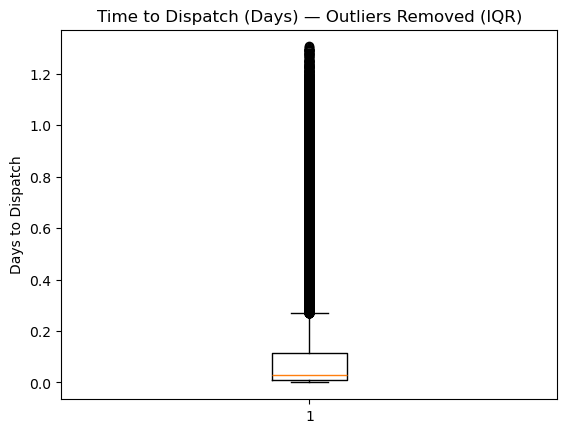

In [102]:

plt.figure()
plt.boxplot(FireData_NO_OUTLIERS["TIME_TO_DISPATCH_DAYS"].dropna())
plt.title("Time to Dispatch (Days) — Outliers Removed (IQR)")
plt.ylabel("Days to Dispatch")
plt.show()

In [103]:
FireData_CLEAN["TIME_TO_DISPATCH"].dtype

dtype('<m8[ns]')

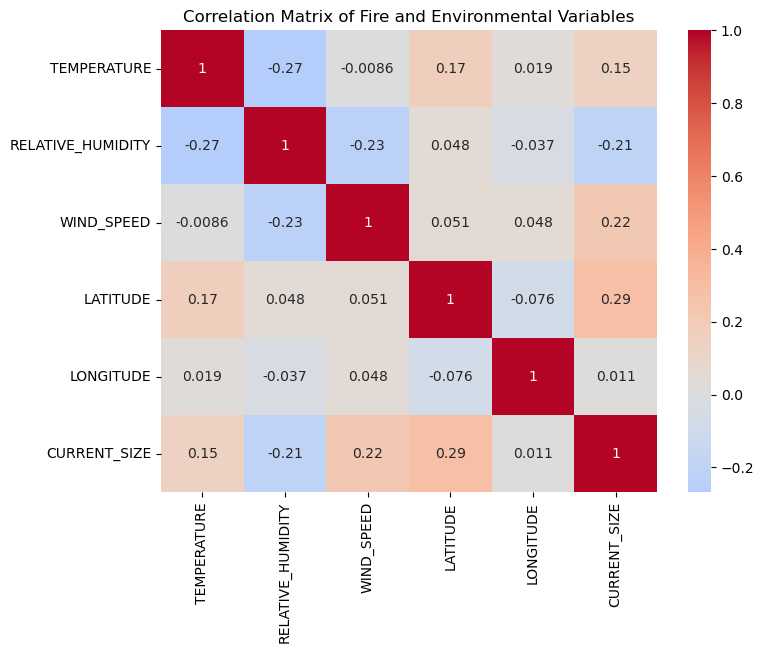

In [104]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select numeric columns only
corr_cols = [
    "TEMPERATURE",
    "RELATIVE_HUMIDITY",
    "WIND_SPEED",
    "LATITUDE",
    "LONGITUDE",
    "CURRENT_SIZE"
]

corr_data = FireData_CLEAN[corr_cols].dropna()

# Compute correlation matrix (Spearman is robust to skew/outliers)
corr_matrix = corr_data.corr(method="spearman")

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="coolwarm",
    center=0
)
plt.title("Correlation Matrix of Fire and Environmental Variables")
plt.show()


In [105]:
FireData_CLEAN[
    ["TIME_TO_DISPATCH_DAYS", "TEMPERATURE", "RELATIVE_HUMIDITY", "WIND_SPEED", "CURRENT_SIZE"]
].corr()


,TIME_TO_DISPATCH_DAYS,TEMPERATURE,RELATIVE_HUMIDITY,WIND_SPEED,CURRENT_SIZE
TIME_TO_DISPATCH_DAYS,1.000000,-0.058777,-0.014321,0.016542,-0.003079
TEMPERATURE,-0.058777,1.000000,-0.282986,-0.017786,0.030058
RELATIVE_HUMIDITY,-0.014321,-0.282986,1.000000,-0.175809,-0.029563
WIND_SPEED,0.016542,-0.017786,-0.175809,1.000000,0.050610
CURRENT_SIZE,-0.003079,0.030058,-0.029563,0.050610,1.000000


In [106]:
FireData_CLEAN["RH_BIN"] = pd.cut(
    FireData_CLEAN["RELATIVE_HUMIDITY"],
    bins=[0, 30, 60, 100],
    labels=["Low", "Medium", "High"]
)

FireData_CLEAN.groupby("RH_BIN")["CURRENT_SIZE"].median()


C:\Users\samkl\AppData\Local\Temp\ipykernel_16656\631782405.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  FireData_CLEAN.groupby("RH_BIN")["CURRENT_SIZE"].median()


RH_BIN
Low       0.10
Medium    0.10
High      0.01
Name: CURRENT_SIZE, dtype: float64

<Axes: xlabel='LAT_BIN'>

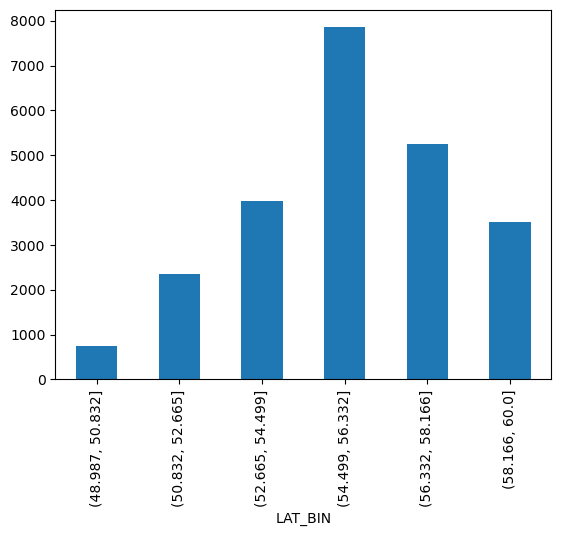

In [107]:
FireData_CLEAN["LAT_BIN"] = pd.cut(
    FireData_CLEAN["LATITUDE"],
    bins=6
)

FireData_CLEAN["LAT_BIN"].value_counts().sort_index()

FireData_CLEAN["LAT_BIN"].value_counts().sort_index().plot(kind="bar")

#Smaller lat is south, Larger Lat is North 


C:\Users\samkl\AppData\Local\Temp\ipykernel_16656\3580962189.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["LAT_BIN", "TRUE_CAUSE"])


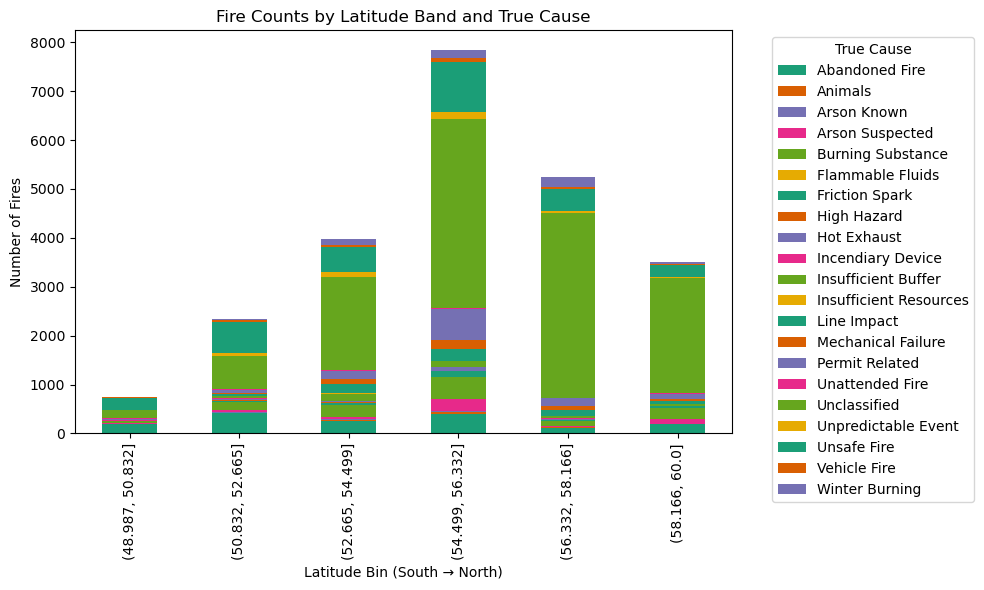

In [108]:
grouped = (
    FireData_CLEAN
    .groupby(["LAT_BIN", "TRUE_CAUSE"])
    .size()
    .unstack(fill_value=0)
)


import matplotlib.pyplot as plt

colors = [
    "#1b9e77",  # green
    "#d95f02",  # orange
    "#7570b3",  # purple
    "#e7298a",  # pink
    "#66a61e",  # olive
    "#e6ab02",  # mustard
]

grouped.plot(
    kind="bar",
    stacked=True,
    figsize=(10, 6),
    color=colors
)

plt.xlabel("Latitude Bin (South → North)")
plt.ylabel("Number of Fires")
plt.title("Fire Counts by Latitude Band and True Cause")
plt.legend(
    title="True Cause",
    bbox_to_anchor=(1.05, 1),
    loc="upper left"
)
plt.tight_layout()
plt.show()



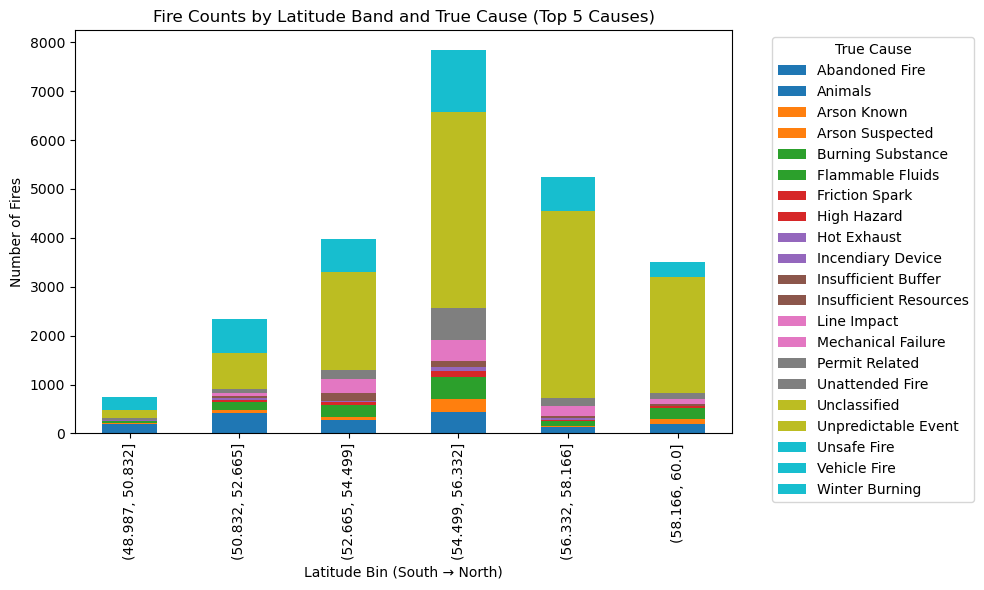

In [109]:
top_causes = (
    FireData_CLEAN["TRUE_CAUSE"]
    .value_counts()
    .head(5)
    .index
)

df_top = FireData_CLEAN[
    FireData_CLEAN["TRUE_CAUSE"].isin(top_causes)
]


grouped.plot(
    kind="bar",
    stacked=True,
    figsize=(10, 6),
    colormap="tab10"
)

plt.xlabel("Latitude Bin (South → North)")
plt.ylabel("Number of Fires")
plt.title("Fire Counts by Latitude Band and True Cause (Top 5 Causes)")
plt.legend(
    title="True Cause",
    bbox_to_anchor=(1.05, 1),
    loc="upper left"
)
plt.tight_layout()
plt.show()


<Axes: xlabel='MONTH'>

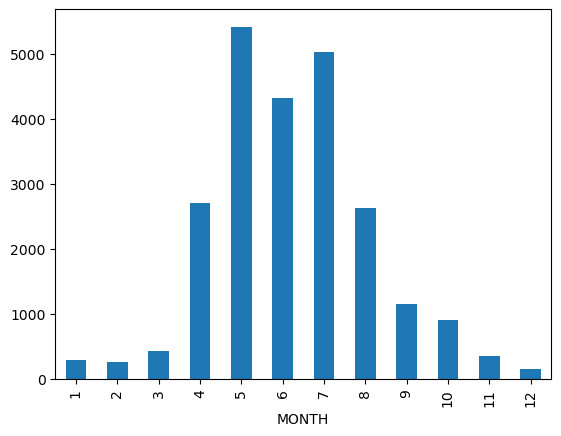

In [110]:
FireData_CLEAN["MONTH"] = FireData_CLEAN["FIRE_START_DATE"].dt.month

FireData_CLEAN.groupby("MONTH").size().plot(kind="bar")


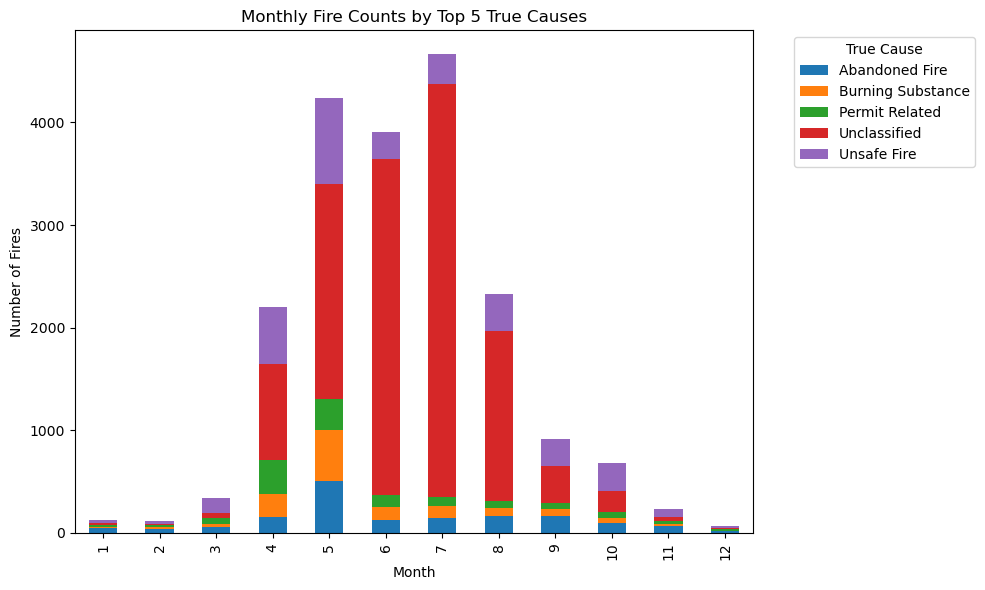

In [111]:
import matplotlib.pyplot as plt

# Select top 5 causes to keep the chart readable
top_causes = (
    FireData_CLEAN["TRUE_CAUSE"]
    .value_counts()
    .head(5)
    .index
)

# Filter data
df_top = FireData_CLEAN[FireData_CLEAN["TRUE_CAUSE"].isin(top_causes)]

# Group and reshape
monthly_cause = (
    df_top
    .groupby(["MONTH", "TRUE_CAUSE"])
    .size()
    .unstack(fill_value=0)
)

# Plot
monthly_cause.plot(
    kind="bar",
    stacked=True,
    figsize=(10, 6)
)

plt.xlabel("Month")
plt.ylabel("Number of Fires")
plt.title("Monthly Fire Counts by Top 5 True Causes")
plt.legend(title="True Cause", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


<Axes: title={'center': 'TEMPERATURE'}, xlabel='TRUE_CAUSE'>

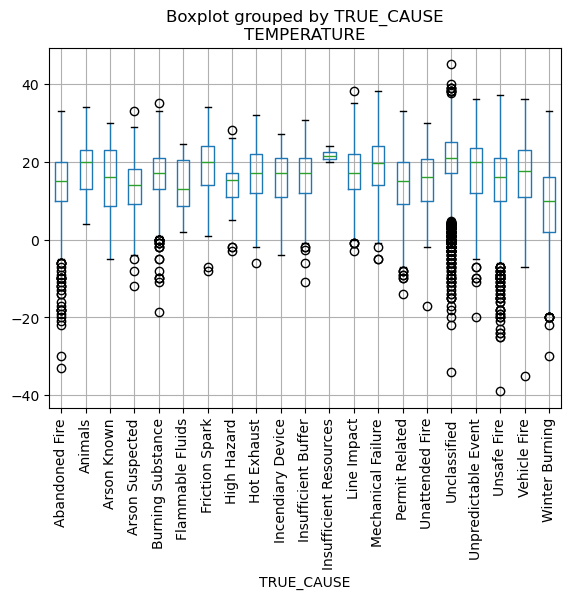

In [112]:
FireData_CLEAN.boxplot(
    column="TEMPERATURE",
    by="TRUE_CAUSE",
    rot=90
)


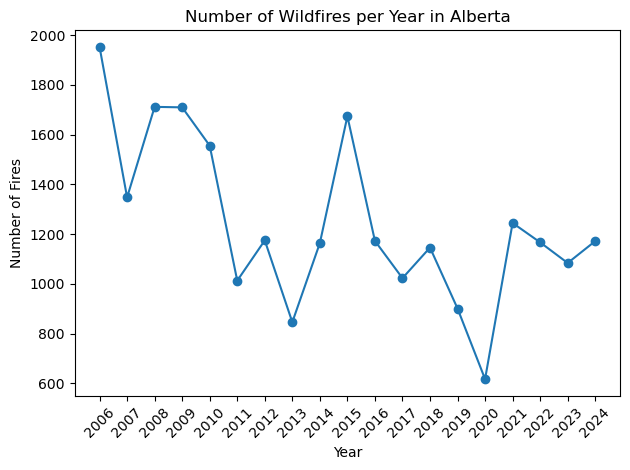

In [113]:
import matplotlib.pyplot as plt

# Aggregate fires by year
fires_by_year = (
    FireData_CLEAN
    .groupby("YEAR")
    .size()
)

plt.figure()
plt.plot(fires_by_year.index, fires_by_year.values, marker="o")

# Force integer year ticks
plt.xticks(
    ticks=range(2006, 2025),
    rotation=45
)

plt.xlabel("Year")
plt.ylabel("Number of Fires")
plt.title("Number of Wildfires per Year in Alberta")

plt.tight_layout()
plt.show()


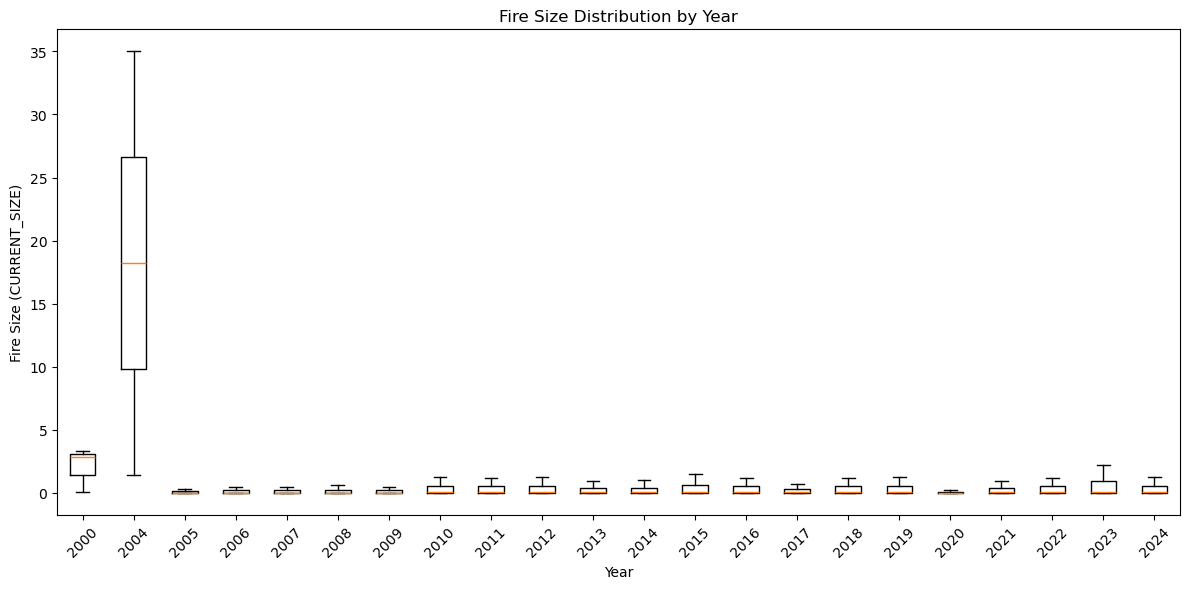

In [114]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure FIRE_START_DATE exists and extract YEAR
FireData_CLEAN["YEAR"] = pd.to_datetime(
    FireData_CLEAN["FIRE_START_DATE"],
    errors="coerce"
).dt.year

# Remove missing or zero sizes if needed
df_size = FireData_CLEAN[
    FireData_CLEAN["CURRENT_SIZE"].notna() &
    (FireData_CLEAN["CURRENT_SIZE"] > 0)
]

# Sort years so boxplots are in order
years = sorted(df_size["YEAR"].unique())

# Prepare data for boxplot
data_by_year = [
    df_size.loc[df_size["YEAR"] == y, "CURRENT_SIZE"]
    for y in years
]

plt.figure(figsize=(12, 6))
plt.boxplot(data_by_year, showfliers=False)
plt.xticks(
    ticks=range(1, len(years) + 1),
    labels=years,
    rotation=45
)
plt.xlabel("Year")
plt.ylabel("Fire Size (CURRENT_SIZE)")
plt.title("Fire Size Distribution by Year")
plt.tight_layout()
plt.show()


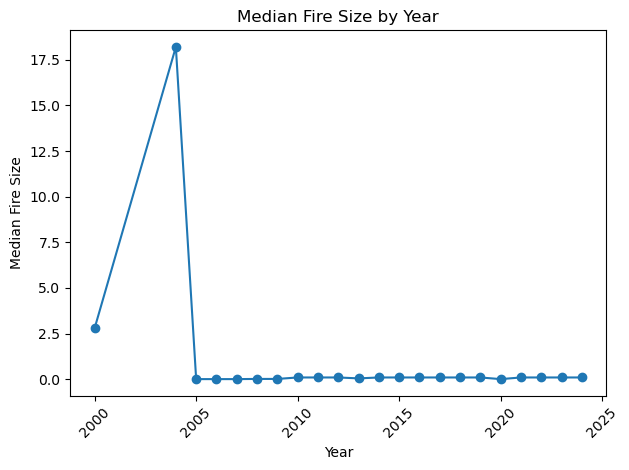

In [115]:
import matplotlib.pyplot as plt

yearly_median = (
    FireData_CLEAN
    .groupby("YEAR")["CURRENT_SIZE"]
    .median()
)

plt.figure()
plt.plot(yearly_median.index, yearly_median.values, marker="o")
plt.xlabel("Year")
plt.ylabel("Median Fire Size")
plt.title("Median Fire Size by Year")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [116]:
import matplotlib.pyplot as plt

# Ensure YEAR exists
FireData_CLEAN["YEAR"] = FireData_CLEAN["FIRE_START_DATE"].dt.year

yearly_stats = (
    FireData_CLEAN
    .groupby("YEAR")
    .agg(
        median_size=("CURRENT_SIZE", "median"),
        mean_size=("CURRENT_SIZE", "mean"),
        fire_count=("CURRENT_SIZE", "count")
    )
    .reset_index()
)

yearly_stats


,YEAR,median_size,mean_size,fire_count
0,2000,2.80,2.046667,3
1,2004,18.20,18.200000,2
2,2005,0.01,1.026667,15
3,2006,0.01,61.567137,1928
4,2007,0.01,76.304278,1358
5,2008,0.02,12.265747,1707
6,2009,0.02,39.872850,1677
7,2010,0.10,50.755450,1600
8,2011,0.10,828.248839,973
9,2012,0.10,320.254888,1205


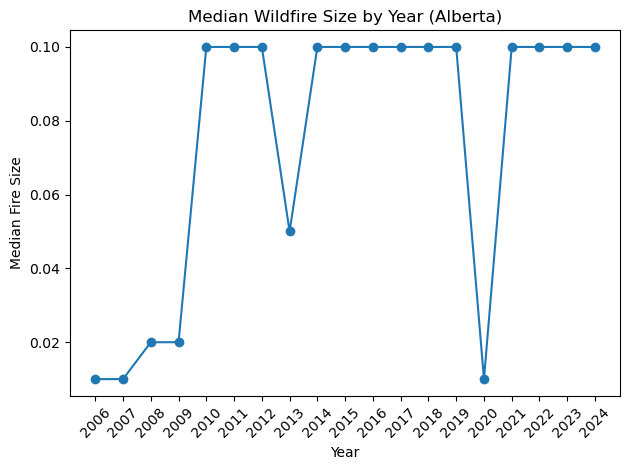

In [117]:
import matplotlib.pyplot as plt

# Aggregate by year
yearly_stats = (
    FireData_CLEAN
    .groupby("YEAR")
    .agg(
        median_size=("CURRENT_SIZE", "median"),
        fire_count=("CURRENT_SIZE", "count")
    )
    .reset_index()
)

# Remove years with too few fires (outlier years like 2004)
yearly_stats = yearly_stats[yearly_stats["fire_count"] >= 50]

# Plot median fire size by year
plt.figure()
plt.plot(
    yearly_stats["YEAR"],
    yearly_stats["median_size"],
    marker="o"
)

plt.xlabel("Year")
plt.ylabel("Median Fire Size")
plt.title("Median Wildfire Size by Year (Alberta)")

plt.xticks(
    yearly_stats["YEAR"],
    rotation=45
)

plt.tight_layout()
plt.show()


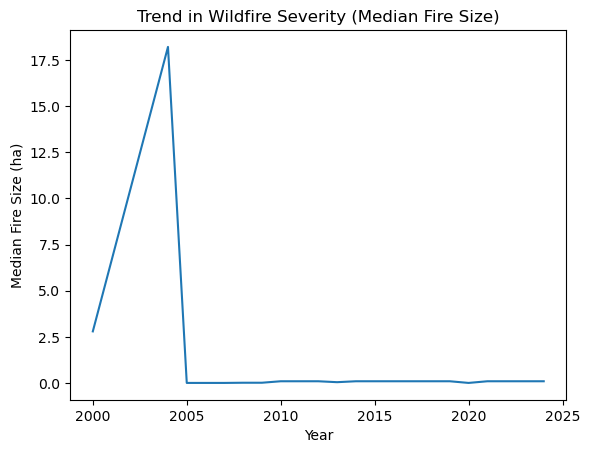

In [118]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure numeric
FireData_CLEAN["CURRENT_SIZE"] = pd.to_numeric(
    FireData_CLEAN["CURRENT_SIZE"], errors="coerce"
)

# Drop missing sizes
severity_df = FireData_CLEAN.dropna(subset=["CURRENT_SIZE"])

# Aggregate by year
severity_trend = (
    severity_df
    .groupby("YEAR")["CURRENT_SIZE"]
    .median()
    .reset_index()
)

# Plot
plt.figure()
plt.plot(severity_trend["YEAR"], severity_trend["CURRENT_SIZE"])
plt.xlabel("Year")
plt.ylabel("Median Fire Size (ha)")
plt.title("Trend in Wildfire Severity (Median Fire Size)")
plt.show()


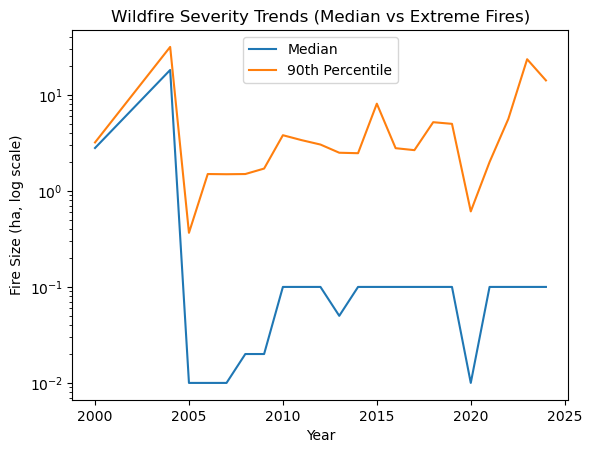

In [119]:
p90_trend = (
    severity_df
    .groupby("YEAR")["CURRENT_SIZE"]
    .quantile(0.9)
    .reset_index()
)

plt.figure()
plt.plot(severity_trend["YEAR"], severity_trend["CURRENT_SIZE"], label="Median")
plt.plot(p90_trend["YEAR"], p90_trend["CURRENT_SIZE"], label="90th Percentile")
plt.yscale("log")
plt.xlabel("Year")
plt.ylabel("Fire Size (ha, log scale)")
plt.title("Wildfire Severity Trends (Median vs Extreme Fires)")
plt.legend()
plt.show()


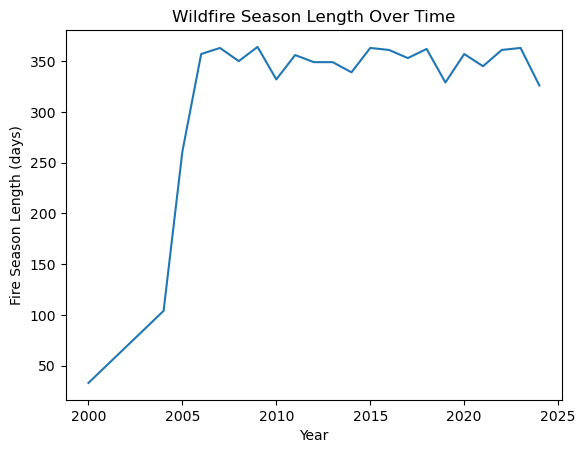

In [120]:
# Convert to datetime
FireData_CLEAN["FIRE_START_DATE"] = pd.to_datetime(
    FireData_CLEAN["FIRE_START_DATE"], errors="coerce"
)

# Drop missing dates
season_df = FireData_CLEAN.dropna(subset=["FIRE_START_DATE"])

# Day of year
season_df["DOY"] = season_df["FIRE_START_DATE"].dt.dayofyear

# Compute season bounds
season_length = (
    season_df
    .groupby("YEAR")
    .agg(
        first_fire=("DOY", "min"),
        last_fire=("DOY", "max")
    )
    .reset_index()
)

season_length["season_length_days"] = (
    season_length["last_fire"] - season_length["first_fire"]
)

# Plot season length
plt.figure()
plt.plot(season_length["YEAR"], season_length["season_length_days"])
plt.xlabel("Year")
plt.ylabel("Fire Season Length (days)")
plt.title("Wildfire Season Length Over Time")
plt.show()


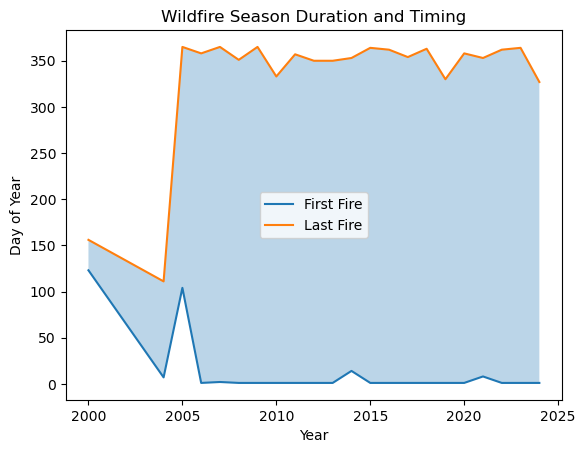

In [121]:
plt.figure()

plt.fill_between(
    season_length["YEAR"],
    season_length["first_fire"],
    season_length["last_fire"],
    alpha=0.3
)

plt.plot(season_length["YEAR"], season_length["first_fire"], label="First Fire")
plt.plot(season_length["YEAR"], season_length["last_fire"], label="Last Fire")

plt.xlabel("Year")
plt.ylabel("Day of Year")
plt.title("Wildfire Season Duration and Timing")
plt.legend()
plt.show()


C:\Users\samkl\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



===== Logistic Regression =====
                       precision    recall  f1-score   support

Non-Large Fires (A–C)      0.994     0.922     0.956      4562
    Large Fires (D–E)      0.292     0.845     0.434       174

             accuracy                          0.919      4736
            macro avg      0.643     0.883     0.695      4736
         weighted avg      0.968     0.919     0.937      4736



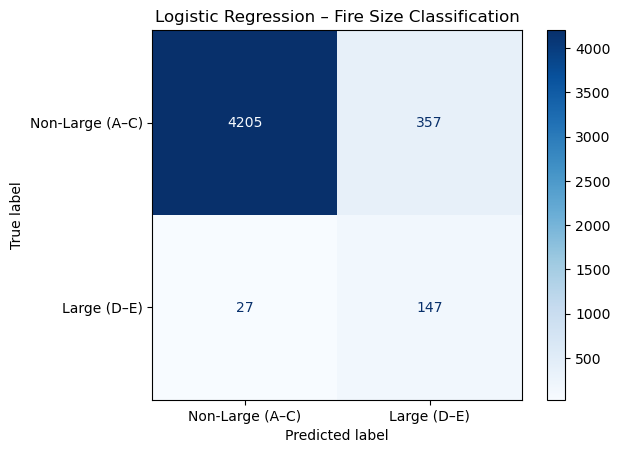

PR-AUC (Average Precision): 0.6190
ROC-AUC: 0.9492

===== Random Forest =====
                       precision    recall  f1-score   support

Non-Large Fires (A–C)      0.964     1.000     0.982      4562
    Large Fires (D–E)      0.833     0.029     0.056       174

             accuracy                          0.964      4736
            macro avg      0.899     0.514     0.519      4736
         weighted avg      0.959     0.964     0.948      4736



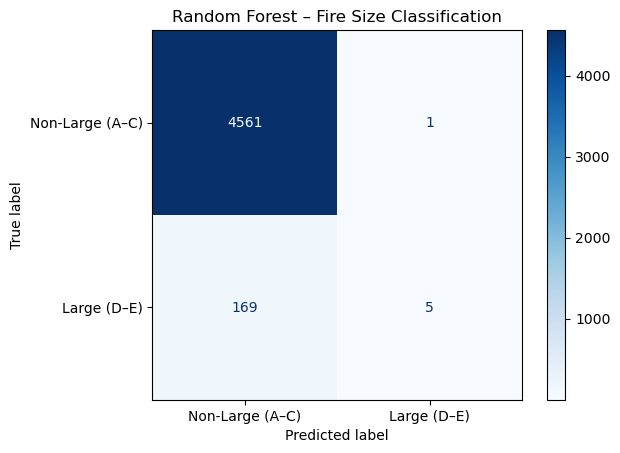

PR-AUC (Average Precision): 0.6412
ROC-AUC: 0.9351


In [122]:
# ===== Logistic Regression + Random Forest (handles datetime columns) =====

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    average_precision_score,
    roc_auc_score
)


# 1) Target

df = FireData_CLEAN.copy()

df = df[df["SIZE_CLASS"].isin(["A", "B", "C", "D", "E"])].copy()
df["is_large_fire"] = df["SIZE_CLASS"].isin(["D", "E"]).astype(int)

# --------------------------------------------------
# 2) Convert datetime columns -> numeric features
#    (keeps signal like seasonality without breaking numpy)
# --------------------------------------------------
datetime_cols = df.select_dtypes(include=["datetime64[ns]", "datetime64"]).columns.tolist()

for c in datetime_cols:
    # Extract parts
    df[f"{c}_year"] = df[c].dt.year
    df[f"{c}_month"] = df[c].dt.month
    df[f"{c}_doy"] = df[c].dt.dayofyear
    # Optional: weekday can help sometimes
    df[f"{c}_dow"] = df[c].dt.dayofweek

# Drop original datetime columns
df = df.drop(columns=datetime_cols)

# --------------------------------------------------
# 3) Feature selection (drop leakage + IDs + target)
# --------------------------------------------------
drop_cols = [
    "is_large_fire",
    "SIZE_CLASS",
    "CURRENT_SIZE",   # usually leaks the outcome size
    "FIRE_NUMBER"     # ID-like
]

leak_cols = [
    "UNDER_CONTROL",
    "EXTINGUISHED",
    "FIRE_FIGHTING_START_SIZE",
    "ASSESSMENT_HECTARES",
    "FIRE_SPREAD_RATE",
    "TIME_TO_DISPATCH",
    "TIME_TO_DISPATCH_DAYS"
]

drop_cols += [c for c in leak_cols if c in df.columns]

X = df.drop(columns=[c for c in drop_cols if c in df.columns])
y = df["is_large_fire"]

# --------------------------------------------------
# 4) Split
# --------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --------------------------------------------------
# 5) Preprocessing
# --------------------------------------------------
cat_cols = X_train.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
num_cols = [c for c in X_train.columns if c not in cat_cols]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ],
    remainder="drop"
)

# --------------------------------------------------
# 6) Models
# --------------------------------------------------
log_reg = Pipeline(steps=[
    ("prep", preprocess),
    ("model", LogisticRegression(max_iter=2000, class_weight="balanced", random_state=42))
])

rf = Pipeline(steps=[
    ("prep", preprocess),
    ("model", RandomForestClassifier(
        n_estimators=400,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    ))
])

log_reg.fit(X_train, y_train)
rf.fit(X_train, y_train)

# --------------------------------------------------
# 7) Evaluation
# --------------------------------------------------
def eval_model(name, model, X_test, y_test):
    print(f"\n===== {name} =====")

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    print(classification_report(
        y_test, y_pred,
        target_names=["Non-Large Fires (A–C)", "Large Fires (D–E)"],
        digits=3
    ))

    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm, display_labels=["Non-Large (A–C)", "Large (D–E)"]).plot(cmap="Blues")
    plt.title(f"{name} – Fire Size Classification")
    plt.show()

    print(f"PR-AUC (Average Precision): {average_precision_score(y_test, y_prob):.4f}")
    print(f"ROC-AUC: {roc_auc_score(y_test, y_prob):.4f}")

eval_model("Logistic Regression", log_reg, X_test, y_test)
eval_model("Random Forest", rf, X_test, y_test)
